# Test Anzahl Briefkästen in der Stadt Zürich 
Datum: 21.07.2021

Im Rahmen der Zahl der Woche suchen wir für den «Welttag des Briefschreibens» die aktuelle Anzahl der Briefkästen in der Stadt Zürich.
Dazu wollen wir den [Open-Data-Katalog der Post](https://swisspost.opendatasoft.com/pages/home/) verwenden.

Interessant für unsere Fragestellung scheint der Datensatz «[Zugangspunkte Post](https://swisspost.opendatasoft.com/explore/dataset/zugangspunkte-post/information/)» zu sein. Dieser Datensatz enthält Informationen zu **postalischen Dienstleistungen** und den **Zugangspunkten** der Post. 




<!---  
Dieses Notebook verwendet als Vorlage die Webseite «[Kitas in Berlin - Jupyter Notebook](https://juanitorduz.github.io/kitas_berlin/)» 
---!>

Mit Colab kann **dieses Jupyter-Notebook interaktiv im Browser** gestartet werden:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DonGoginho/myPy_RIS_API/blob/main/RIS_API_AL_Geschaefte.ipynb)


**Inhaltsverzeichnis:**

1. [Daten importieren](#LiesDatenein)
2. [Daten prüfen](#)
3. [Daten analysieren](#Explorative_Analyse)



In [1]:
%pip install geopandas fiona requests folium mplleaflet contextily

Note: you may need to restart the kernel to use updated packages.


## Importiere notwendige Packages:

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona; 
import mplleaflet
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

pd.options.display.float_format = '{:.0f}'.format
#pd.set_option('display.width', 100)
#pd.set_option('display.max_columns', 15)

## Lies Daten ein


Die Daten der Zugangspunkte der Post können entweder als [csv oder json-Datei heruntergeladen](https://swisspost.opendatasoft.com/explore/dataset/zugangspunkte-post/export/) oder per [API-request](https://swisspost.opendatasoft.com/explore/dataset/zugangspunkte-post/api/) abgefragt werden.

Wir schauen uns hier mal beide Möglichkeiten an.

### Importiere den aktuellsten Bestand der Zugangspunkte direkt als CSV oder als JSON vom Datenkatalog

Lade entsprechend den Datensatz via [Export](https://swisspost.opendatasoft.com/explore/dataset/zugangspunkte-post/export/) vom Datenkatalog herunter.

Hier ist jedoch der Nachteil, dass ein gesamtschweizierischer Datensatz mit allen Themen herunter geladen werden muss. Uns interessieren ja eigentlich nur die Briefkästen der Stadt Zürich...





In [21]:
#Direkter csv-Import

csv_url = "https://swisspost.opendatasoft.com/explore/dataset/zugangspunkte-post/download/?format=csv&timezone=Europe/Berlin&lang=de&use_labels_for_header=true&csv_separator=%3B"

df_zugangspunkte_post  = pd.read_csv(
    csv_url, 
    sep=';',
    usecols=["Id", "loc", "x",'POITypeId','POIName_de','address_city', 'address_kantoncode', 'address_zip','address_countrycode',
             'address_street', 'address_technicalplz6','address_gemeindeid', 'geopoint','pickuptime_description_de', 'AdditionalDescription', 'OfferPackage', 'OpeningHoursEvent', 'AccessInformation', 'service_servicetypeid',
       'poityp_de', 'Verarbeitung_de', 'groupename_de','service_de', 'url_de', 'urlmobil_de']
   #names=['stationid','year','month','avgtemp','latitude','longitude','elevation','station','countryid','country'],
   #skiprows=1,
   # parse_dates=[0],
    parse_dates=True,
    #date_parser=lambda x: pd.to_datetime(x, format="%Y"), 
    #index_col="date_time",
    low_memory=False    
    )

df_zugangspunkte_post.head(2)


,Id,POITypeId,POIName_de,address_city,address_kantoncode,address_zip,address_countrycode,address_street,address_technicalplz6,address_gemeindeid,...,OfferPackage,OpeningHoursEvent,AccessInformation,service_servicetypeid,poityp_de,Verarbeitung_de,groupename_de,service_de,url_de,urlmobil_de
0,001PST_001114475,001PST,Post Filiale 1084 Carrouge VD,Carrouge VD,VD,1084,CH,Route du Village 33,108400,5806,...,"[{""@OfferPackageId"": ""001BRPA""}, {""@OfferPacka...",NaN,NaN,001800008,Filiale,kleinere Mengen Briefe und Pakete/Sperrgut,Zahlungsverkehr,Bargeldbezug,NaN,NaN
1,001PST_001114478,001PST,Post Filiale 1033 Cheseaux-sur-Lausanne,Cheseaux-sur-Lausanne,VD,1033,CH,Route d'Yverdon 5,103300,5582,...,"[{""@OfferPackageId"": ""001BRPA""}, {""@OfferPacka...",NaN,NaN,001134032,Filiale,kleinere Mengen Briefe und Pakete/Sperrgut,Briefe und Pakete,PickPost,http://www.post.ch/pickpost,http://www.post.ch/pickpost


In [43]:
df_zugangspunkte_post.info()
#df_zugangspunkte_post.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89853 entries, 0 to 89852
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         89853 non-null  object 
 1   POITypeId                  89853 non-null  object 
 2   POIName_de                 89853 non-null  object 
 3   address_city               89853 non-null  object 
 4   address_kantoncode         89853 non-null  object 
 5   address_zip                89853 non-null  int64  
 6   address_countrycode        89853 non-null  object 
 7   address_street             75401 non-null  object 
 8   address_technicalplz6      71785 non-null  float64
 9   address_gemeindeid         89853 non-null  int64  
 10  geopoint                   89842 non-null  object 
 11  pickuptime_description_de  32272 non-null  object 
 12  AdditionalDescription      16233 non-null  object 
 13  OfferPackage               71512 non-null  obj

Speichere das csv auf Grund seiner Grösse lokal ab

In [23]:
df_zugangspunkte_post.to_csv("//szh.loc/ssz/users/sszsim/Dokumente/myPy/anfragen/briefkaesten_post_zuerich/download/zugangspunkte_post.csv")
print('done')

done


### Auswahl der Briefkästen in Zürich aus allen Zugangspunkten 

Query nur jene, dem `poityp_de == "Briefeinwurf"` in der Stadt Zürich (`address_gemeindeid == 261`) vorkommen.



In [35]:
df_briefkaesten_zuerich_all = df_zugangspunkte_post.query('poityp_de =="Briefeinwurf" & address_gemeindeid == 261')
df_briefkaesten_zuerich_all.columns
#df_briefkaesten_zuerich.head(2)

Index(['Id', 'POITypeId', 'POIName_de', 'address_city', 'address_kantoncode',
       'address_zip', 'address_countrycode', 'address_street',
       'address_technicalplz6', 'address_gemeindeid', 'geopoint',
       'pickuptime_description_de', 'AdditionalDescription', 'OfferPackage',
       'OpeningHoursEvent', 'AccessInformation', 'service_servicetypeid',
       'poityp_de', 'Verarbeitung_de', 'groupename_de', 'service_de', 'url_de',
       'urlmobil_de'],
      dtype='object')

Verwende nur die relevanten Attribute

Speichere die Datei als csv ab

In [73]:
#geometry="POINT("+df_briefkaesten_zuerich_all['geopoint']+")"


In [75]:
df_briefkaesten_zuerich = df_briefkaesten_zuerich_all[['Id', 'POITypeId', 'POIName_de', 'address_city', 'address_kantoncode',
       'address_zip', 'address_countrycode', 'address_street', 'address_gemeindeid', 'geopoint','poityp_de']]
df_briefkaesten_zuerich.head(2)

,Id,POITypeId,POIName_de,address_city,address_kantoncode,address_zip,address_countrycode,address_street,address_gemeindeid,geopoint,poityp_de
17829,003BE_00325052,003BE,"Briefeinwurf Zürich, BE Bushaltestelle Glaubte...",Zürich,ZH,8046,CH,Wehntalerstrasse 374,261,"47.41407433,8.52014398",Briefeinwurf
18493,003BE_00324763,003BE,"Briefeinwurf Zürich, Bleicherweg",Zürich,ZH,8002,CH,Bleicherweg 19,261,"47.36781255,8.53569237",Briefeinwurf


In [103]:
df_briefkaesten_zuerich.to_csv("//szh.loc/ssz/users/sszsim/Dokumente/myPy/anfragen/briefkaesten_post_zuerich/output/df_briefkaesten_zuerich.csv")

In [105]:
df_briefkaesten_zuerich.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475 entries, 17829 to 86448
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Id                   475 non-null    object
 1   POITypeId            475 non-null    object
 2   POIName_de           475 non-null    object
 3   address_city         475 non-null    object
 4   address_kantoncode   475 non-null    object
 5   address_zip          475 non-null    int64 
 6   address_countrycode  475 non-null    object
 7   address_street       475 non-null    object
 8   address_gemeindeid   475 non-null    int64 
 9   geopoint             475 non-null    object
 10  poityp_de            475 non-null    object
dtypes: int64(2), object(9)
memory usage: 44.5+ KB


### Importiere die Briefkästen der Stadt Zürich in GeoPandas





Unschön im csv ist, dass das Koordinatenpaar `geopoint` nicht in einem WKT-Format (also POINT(X,Y) ) vorhanden ist und Geopandas das csv daher nicht direkt einlesen kann... Man könnte nun ein neues Attribut erstellen mit der korrekten Schreibweise, z.B. die Variabel `geometry="POINT("+df_briefkaesten_zuerich['geopoint']+")" `
Aber das ist etwas umständlich... wir welchseln hier dann wohl besser von Anfang an auf GeoJSON.

In [94]:
#gdf_briefkaesten_zuerich = gpd.GeoDataFrame(df_briefkaesten_zuerich, geometry="POINT("+df_briefkaesten_zuerich['geopoint']+")")
#gdf_briefkaesten_zuerich

Den Datendownlaod gibt es aber auch als Geodatensätze... als GeoJSON und als Shapefile. Daher lesen wir hier nun mal GeoJSON ein und machen anschliessend nochmals die Selektion.

In [98]:
url_geojson = "https://swisspost.opendatasoft.com/explore/dataset/zugangspunkte-post/download/?format=geojson&timezone=Europe/Berlin&lang=de"

gdf_briefkaesten_geojson = gpd.read_file(url_geojson,
                                         ignore_fields=['pickuptime_description_en','receipttype_de','groupename_de ', 'receipttype_fr', 'poityp_fr', 'description_fr', 'service_en','pickuptime_description_it', 'poityp_it', 'additionaldescription',
       'address_technicalplz6', 'pickuptime_time', 'contact_email_addresse_en', 'groupename_fr',
       'contact_fax', 'service_fr', 'contact_email_addresse_it', 'receipttype_en', 'description_en',
       'description_it', 'poitypeid', 'offerpackage', 'service_servicetypeid', 'contact_email_addresse_fr',
       'groupename_en', 'groupename_it', 'contact_phone', 'receipttype_it', 'pickuptime_description_de', 'pickuptime_description_fr',
       'contact_email_addresse_de', 'service_it', 'url_fr', 'url_it', 'url_de',
       'urlmobil_fr', 'urlmobil_de', 'forbusinesscustomer', 'urlmobil_it',
       'forprivatecustomer', 'urlmobil_en', 'url_en', 'accessinformation',
       'openinghoursevent'],
                                        )
print('done')



done


In [99]:
gdf_briefkaesten_geojson.head(2)


,description_de,address_street,id,poityp_en,address_kantoncode,groupename_de,address_zip,address_gemeindeid,address_countrycode,service_de,address_city,poityp_de,geometry
0,Post Filiale 1084 Carrouge VD,Route du Village 33,001PST_001114475,Branch,VD,Zahlungsverkehr,1084,5806,CH,Bargeldbezug,Carrouge VD,Filiale,POINT (6.77612 46.60509)
1,Post Filiale 1033 Cheseaux-sur-Lausanne,Route d'Yverdon 5,001PST_001114478,Branch,VD,Briefe und Pakete,1033,5582,CH,PickPost,Cheseaux-sur-Lausanne,Filiale,POINT (6.60541 46.58641)


In [100]:
gdf_briefkaesten_geojson_zuerich = gdf_briefkaesten_geojson.query('poityp_de =="Briefeinwurf" & address_gemeindeid == "261"')
#gdf_briefkaesten_geojson_zuerich.head(2)
gdf_briefkaesten_geojson_zuerich.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 475 entries, 17829 to 86448
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   description_de       475 non-null    object  
 1   address_street       475 non-null    object  
 2   id                   475 non-null    object  
 3   poityp_en            475 non-null    object  
 4   address_kantoncode   475 non-null    object  
 5   groupename_de        0 non-null      object  
 6   address_zip          475 non-null    object  
 7   address_gemeindeid   475 non-null    object  
 8   address_countrycode  475 non-null    object  
 9   service_de           0 non-null      object  
 10  address_city         475 non-null    object  
 11  poityp_de            475 non-null    object  
 12  geometry             475 non-null    geometry
dtypes: geometry(1), object(12)
memory usage: 52.0+ KB


Speichere den Datensatz der Briefkästen der Stadt Zürich als GeoJSON ab

In [101]:
gdf_briefkaesten_geojson_zuerich.to_file("//szh.loc/ssz/users/sszsim/Dokumente/myPy/anfragen/briefkaesten_post_zuerich/output/gdf_briefkaesten_geojson_zuerich.geojson", driver='GeoJSON')

<AxesSubplot:>

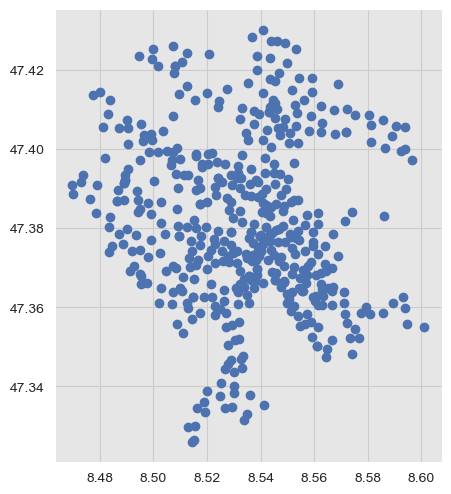

In [102]:
gdf_briefkaesten_geojson_zuerich.plot()

In [46]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html

## Explorative_Analyse
One of the main objectives of this notebook is to do an exploratory data analysis to understand which questions this data set can answer. In addition, also determine its limitations. 

To begin, let us get the number of unique values per feature.


In [120]:
df_briefkaesten_zuerich.head(2)

,Id,POITypeId,POIName_de,address_city,address_kantoncode,address_zip,address_countrycode,address_street,address_gemeindeid,geopoint,poityp_de
17829,003BE_00325052,003BE,"Briefeinwurf Zürich, BE Bushaltestelle Glaubte...",Zürich,ZH,8046,CH,Wehntalerstrasse 374,261,"47.41407433,8.52014398",Briefeinwurf
18493,003BE_00324763,003BE,"Briefeinwurf Zürich, Bleicherweg",Zürich,ZH,8002,CH,Bleicherweg 19,261,"47.36781255,8.53569237",Briefeinwurf


In [106]:
df_briefkaesten_zuerich.apply(lambda x: x.unique().size, axis=0)


Id                     475
POITypeId                1
POIName_de             427
address_city             1
address_kantoncode       1
address_zip             24
address_countrycode      1
address_street         451
address_gemeindeid       1
geopoint               468
poityp_de                1
dtype: int64

In welcher PLZ gibt es am meisten Briefkästen?

In [119]:
 #   .query('kategorie == "Parkbaum"') \
#    .agg(anz_baeume=('objid', 'count'), anz_kinder_va_sk=('objid', 'sum')) \
df_briefkaesten_zuerich \
    .groupby(['address_zip' ]) \
    .agg(anz_briefkaesten=('Id', 'count')) \
    .sort_values('anz_briefkaesten', ascending=False) \
    .head(500)


,anz_briefkaesten
address_zip,
8001,41
8006,30
8032,29
8008,29
8050,29
8004,27
8048,26
8049,24
8057,22


In [114]:
df_briefkaesten_zuerich \
    .groupby(['address_zip','POIName_de' ]) \
    .agg(anz_briefkaesten=('Id', 'count')) \
    .sort_values('address_zip', ascending=True) \
    .head(500)


anz_briefkaesten
address_zip POIName_de                                                          
8001        Briefeinwurf Zürich, BE Standseilbahn Bergstation                  1
            Briefeinwurf Zürich, Löwenstrasse                                  1
            Briefeinwurf Zürich, Mühlegasse                                    1
            Briefeinwurf Zürich, Paradeplatz                                   2
            Briefeinwurf Zürich, Passage Löwenstrasse                          1
...                                                                          ...
8057        Briefeinwurf Zürich, Birchstrasse                                  1
            Briefeinwurf Zürich, Milchbuckstrasse                              1
8064        Briefeinwurf Zürich, Tramendhaltestelle Werdhölzli                 1
            Briefeinwurf Zürich, Altersheim                                    1
            Briefeinwurf Zürich, Tramhaltestelle Tüffenwies                    1

[432 rows x 1 columns]

Welche Baumart ist bei den Parkbäumen die Häufigste?

In [16]:

df_baumkataster_20210718 \
    .groupby(['kategorie','status','baumgattunglat','baumartlat','baumnamelat','baumnamedeu' ]) \
    .agg(anz_baeume=('baumnummer', 'count')) \
    .query('kategorie == "Parkbaum"') \
    .sort_values('anz_baeume', ascending=False) \
    .head(10)




anz_baeume
kategorie status     baumgattunglat baumartlat     baumnamelat         baumnamedeu                                        
Parkbaum  Grünanlage Carpinus       betulus        Carpinus betulus    Gemeine Hain- oder Weissbuche                  3130
                     Taxus          baccata        Taxus baccata       Eibe, Gewöhnliche Eibe                         2107
                     Pinus          sylvestris     Pinus sylvestris    Gewöhnlicher Kiefer, Wald-Kiefer, Föhre        1807
          Obst       Malus          domestica      Malus domestica cv. Apfel-Obstgehölz, Sorte unbekannt              1661
          Grünanlage Acer           campestre      Acer campestre      Feld-Ahorn, Hecken-Ahorn                       1639
                     Betula         pendula        Betula pendula      Sand-Birke, Weiss-Birke                        1600
                     Fraxinus       excelsior      Fraxinus excelsior  Gemeine Esche                                  1581
                     Acer           platanoides    Acer platanoides    Spitz-Ahorn                                    1514
                     Picea          abies          Picea abies         Rottanne, Fichte                               1394
                     Acer           pseudoplatanus Acer pseudoplatanus Berg-Ahorn, Wald-Ahorn                         1263